In [22]:
import pickle
from lime.lime_text import LimeTextExplainer
import pandas as pd
import numpy as np
from tqdm import tqdm
from lime.explanation import Explanation
from typing import Tuple, List
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from joblib import Parallel, delayed
import gensim
import io
import base64
from IPython.display import display, HTML
import re
import plotly.express as px
import matplotlib.patches as mpatches
scaler = MinMaxScaler()
import plotly.graph_objs as go

In [23]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [33]:
# Load the trained logistic regression model
loaded_model = pickle.load(open("models/lreg_w2v_avg_2020.sav", "rb"))
# Load w2v model
model_w2v = pickle.load(open("models/w2v_published_only_english_between_2019 and 2020.model", "rb"))
# Load the test dataset
test_df = pd.read_csv("y_test_2020_2020.csv").drop(columns="Unnamed: 0")

In [4]:
def predict_probabilities_from_text(texts: List[str]) -> np.ndarray:
    """
    Converts a list of texts into feature vectors using a Word2Vec model 
    and predicts probabilities using LR model.
    Parameters:
    - texts (list of str): List of textual data.
    Returns:
    - ndarray: Probabilities predicted by the model for each text.
    """
    vectors = []
    # Convert each text into a feature vector
    for text in texts:
        # Tokenize the text and filter words present in the Word2Vec model
        words = [word for word in text.split() if word in model_w2v.wv]
        # If there are valid words, compute the mean vector
        if words:
            vector = np.mean([model_w2v.wv[word] for word in words], axis=0)
            vectors.append(vector)
        else:
            # If no valid words, append a zero vector
            vectors.append(np.zeros(model_w2v.vector_size))
    # Predict probabilities using the preloaded model
    return loaded_model.predict_proba(vectors)

# LIME applied on test_df

In [ ]:
def process_instance(i, text, true_label, word_cache):
    explained = explainer.explain_instance(text, predict_probabilities_from_text, num_features=15)
    lime_word_importances = explained.as_list()
    importances_df = pd.DataFrame(lime_word_importances, columns=["word", "importance"])
    importances_df["true_label"] = true_label
    importances_df["abstract_text"] = text
    importances_df["intercept"] = explained.intercept[1]
    importances_df["prediction_local"] = explained.local_pred[0]

    for word in importances_df["word"].unique():
        if word not in word_cache:
            word_cache[word] = {}
            word_cache[word]["predicted_proba"] = predict_probabilities_from_text([word])[0][1]
            word_cache[word]["cnt_of_articles_with_targ"] = (test_df["abstract_cleaned"].str.contains(word) & test_df["target"].notna()).sum()
            word_cache[word]["%_of_high_cit"] = (test_df["abstract_cleaned"].str.contains(word) & (test_df["target"] == 1)).sum() / word_cache[word]["cnt_of_articles_with_targ"]

        importances_df.loc[importances_df["word"] == word, "predicted_proba"] = word_cache[word]["predicted_proba"]
        importances_df.loc[importances_df["word"] == word, "cnt_of_articles_with_targ"] = word_cache[word]["cnt_of_articles_with_targ"]
        importances_df.loc[importances_df["word"] == word, "%_of_high_cit"] = word_cache[word]["%_of_high_cit"]

    return importances_df

# DataFrame to store LIME results
lime_df = pd.DataFrame(columns=["word", "importance", "true_label", "cnt_of_articles_with_targ", "%_of_high_cit"])

# Initialize the LIME text explainer
explainer = LimeTextExplainer(class_names=["Low", "High"], random_state=42)

word_cache = {}

# Use all available CPUs
results = Parallel(n_jobs=-1)(delayed(process_instance)(i, text, true_label, word_cache) for i, (text, true_label) in enumerate(tqdm(zip(test_df["abstract_cleaned"], test_df["target"]))))

# Combine all results into one dataframe
lime_df = pd.concat(results).reset_index(drop=True)

lime_df.to_csv("lime_data_correct.csv")


In [69]:
def calculate_word_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates various metrics related to word importance, such as the number of occurrences,
    positive importances, and average importances for high and low citation articles.
    Parameters:
    - df (pd.DataFrame): DataFrame containing word importances and true labels.
    Returns:
    - pd.DataFrame: DataFrame with new columns containing the calculated metrics.
    """

    # Calculate absolute importance
    df['abs_importance'] = df['importance'].abs()

    # Global LIME Importance (square root of the sum of absolute importance)
    global_lime_importance = np.sqrt(df.groupby('word')['abs_importance'].sum())

    # Global Average Importance
    count_nonzero_importance = df.groupby('word')['abs_importance'].apply(lambda x: (x != 0).sum())
    global_avg_importance = df.groupby('word')['abs_importance'].sum() / count_nonzero_importance

    # Normalize LIME importance per class
    df['normalized_importance'] = df.groupby(['word', 'true_label'])['abs_importance'].transform(lambda x: x / x.sum())

    # Calculate the entropy values for each word based on normalized importance
    grouped = df.groupby(['word', 'true_label'])['normalized_importance'].mean().reset_index()
    grouped = grouped.pivot(index='word', columns='true_label', values='normalized_importance').fillna(0)
    
    # Calculate Shannon entropy for the distribution of normalized importance over classes
    entropy_values = grouped.apply(lambda x: entropy(x + 1e-9), axis=1)

    # Normalize the entropy values
    min_entropy = entropy_values.min()
    max_entropy = entropy_values.max()
    entropy_values_normalized = (entropy_values - min_entropy) / (max_entropy - min_entropy)

    # Calculate the Global Homogeneity-Weighted Importance for each word
    global_homogeneity_importance = (1 - entropy_values_normalized) * global_lime_importance


    total_occurrences = df.groupby('word').size()
    avg_predict_proba = df.groupby('word')['predicted_proba'].mean()

    # Map the calculated metrics back to the original dataframe
    metrics_df = df.assign(
        total_occurrences=df['word'].map(total_occurrences),
        avg_predict_proba=df['word'].map(avg_predict_proba),
        global_lime_importance=df['word'].map(global_lime_importance),
        global_avg_importance= df["word"].map(global_avg_importance),
        global_homogeneity_importance=df['word'].map(global_homogeneity_importance),
    )

    metrics_df.fillna(0, inplace=True)
    return metrics_df

def scale_lime_metrics(df):
    # Function to apply scaling for a specific column
    def scale_column(column_name, new_column_name):
        scaler = MinMaxScaler(feature_range=(0, 0.5))
        mask_below = df[column_name] < 0.5
        df.loc[mask_below, new_column_name] = scaler.fit_transform(df.loc[mask_below, column_name].values.reshape(-1, 1)).flatten()

        scaler.feature_range = (0.5, 1.0)
        mask_above = df[column_name] >= 0.5
        df.loc[mask_above, new_column_name] = scaler.fit_transform(df.loc[mask_above, column_name].values.reshape(-1, 1)).flatten()

    scale_column('importance', 'importance_scaled')
    #scale_column('global_avg_importance', 'global_avg_importance_scaled')
    scaler = MinMaxScaler()
    df["global_lime_importance_scaled"] = scaler.fit_transform(df['global_lime_importance'].values.reshape(-1, 1))
    df['global_avg_importance_scaled'] = scaler.fit_transform(df["global_avg_importance"].values.reshape(-1, 1))
    df['global_homogeneity_importance_scaled'] = scaler.fit_transform(df["global_homogeneity_importance"].values.reshape(-1, 1))

    return df

## Load LIME results

In [75]:
lime_df = pd.read_csv("lime_data_correct_with_doi_final_imp.csv").drop(columns="Unnamed: 0")

## Calculate Global Word Metrics

In [76]:
lime_df_word_metrics = calculate_word_metrics(lime_df)
lime_df_word_metrics = scale_lime_metrics(lime_df_word_metrics)

In [77]:
df_word_metrics_no_duplicates = lime_df_word_metrics.drop_duplicates(subset='word', keep='first')

## Evaluate Global Scores - AOPCglobal

In [9]:
def remove_words(text, words_to_remove):
    return ' '.join([word for word in text.split() if word not in words_to_remove])

# Define the function to compute the drop in predicted probability for one metric
def compute_AOPCglobal(df, df_abstracts, metric_colname, max_K=10):
    # Sort words by their global importance
    ranked_words_global = df.groupby("word")[metric_colname].mean().sort_values(ascending=False).index.tolist()
    
    # Storage for the average drop in probability for each K
    avg_drops = []
    
    # Iterate for each K
    for K in tqdm(range(0, max_K + 1)):
        # Compute the drop in probability for each document
        drops = []
        for text in df_abstracts["abstract_text"].unique():
            # Find the top K globally ranked words that are present in this document
            words_in_text = set(text.split())
            top_words_in_text = [word for word in ranked_words_global if word in words_in_text][:K]
            
            altered_text = remove_words(text, top_words_in_text)
            
            # If no change in the text, no need to predict again
            if text == altered_text:
                drop = 0
            else:
                original_pred = predict_probabilities_from_text([text])[0][1]
                altered_pred = predict_probabilities_from_text([altered_text])[0][1]
                drop = original_pred - altered_pred
            
            drops.append(drop)
        
        # Average drop
        avg_drops.append(np.mean(drops))
    
    return avg_drops


### Compute AOPCglobal for SMER score

In [56]:
df_smer = pd.read_csv("SMER_word_score.csv").drop(columns=["Unnamed: 0"])
AOPC_SMER = compute_AOPCglobal(df_smer, lime_df_word_metrics, 'score', max_K=10)

100%|██████████| 11/11 [11:35<00:00, 63.21s/it]


### Compute AOPCglobal for LIME scores

In [57]:
# Compute AOPCglobal for each metric
max_K = 10  
AOPC_LIME = compute_AOPCglobal(lime_df_word_metrics,lime_df_word_metrics, "global_lime_importance", max_K)
AOPC_Avg = compute_AOPCglobal(lime_df_word_metrics, lime_df_word_metrics, "global_avg_importance", max_K)
AOPC_Homogeneity = compute_AOPCglobal(lime_df_word_metrics, lime_df_word_metrics, "global_homogeneity_importance", max_K)

100%|██████████| 11/11 [04:35<00:00, 25.06s/it]


### Compute AOPCglobal to obtain Random Baseline

In [58]:
random_ranked_words = lime_df_word_metrics["word"].unique()
np.random.seed(40)
np.random.shuffle(random_ranked_words)
random_df = lime_df_word_metrics.copy()
random_df["random_importance"] = random_df["word"].map({word: rank for rank, word in enumerate(random_ranked_words)})

AOPC_Random = compute_AOPCglobal(random_df, lime_df_word_metrics, "random_importance", max_K)

100%|██████████| 11/11 [04:35<00:00, 25.00s/it]


## Calculate Area Under AOPCglobal

In [59]:
df_results = pd.DataFrame({"AOPC_RANDOM": AOPC_Random,
"AOPC_HOMOGENEITY": AOPC_Homogeneity,
"AOPC_LIME": AOPC_LIME,
"AOPC_AVG": AOPC_Avg ,
"AOPC_SMER": AOPC_SMER,
})

In [39]:
df_results = pd.read_csv("aopc_results.csv")

In [60]:
def area_between_curves(df, curve1, curve2):
    return 0.5 * sum([(df[curve1][i] + df[curve1][i-1] - df[curve2][i] - df[curve2][i-1]) for i in range(1, len(df[curve1]))])

results = pd.DataFrame({
    "area_under_APOC_global_lime": area_between_curves(df_results, "AOPC_LIME", "AOPC_RANDOM"),
    "area_under_APOC_smer": area_between_curves(df_results, "AOPC_SMER", "AOPC_RANDOM"),
    "area_under_APOC_avg_lime": area_between_curves(df_results, "AOPC_AVG", "AOPC_RANDOM"),
    "area_under_APOC_homogenity": area_between_curves(df_results, "AOPC_HOMOGENEITY", "AOPC_RANDOM")
}, index=[0])

results_transposed = results.T
results_transposed.columns = ['value']
results_transposed

,value
area_under_APOC_global_lime,0.325154
area_under_APOC_smer,0.704173
area_under_APOC_avg_lime,0.670689
area_under_APOC_homogenity,0.122686


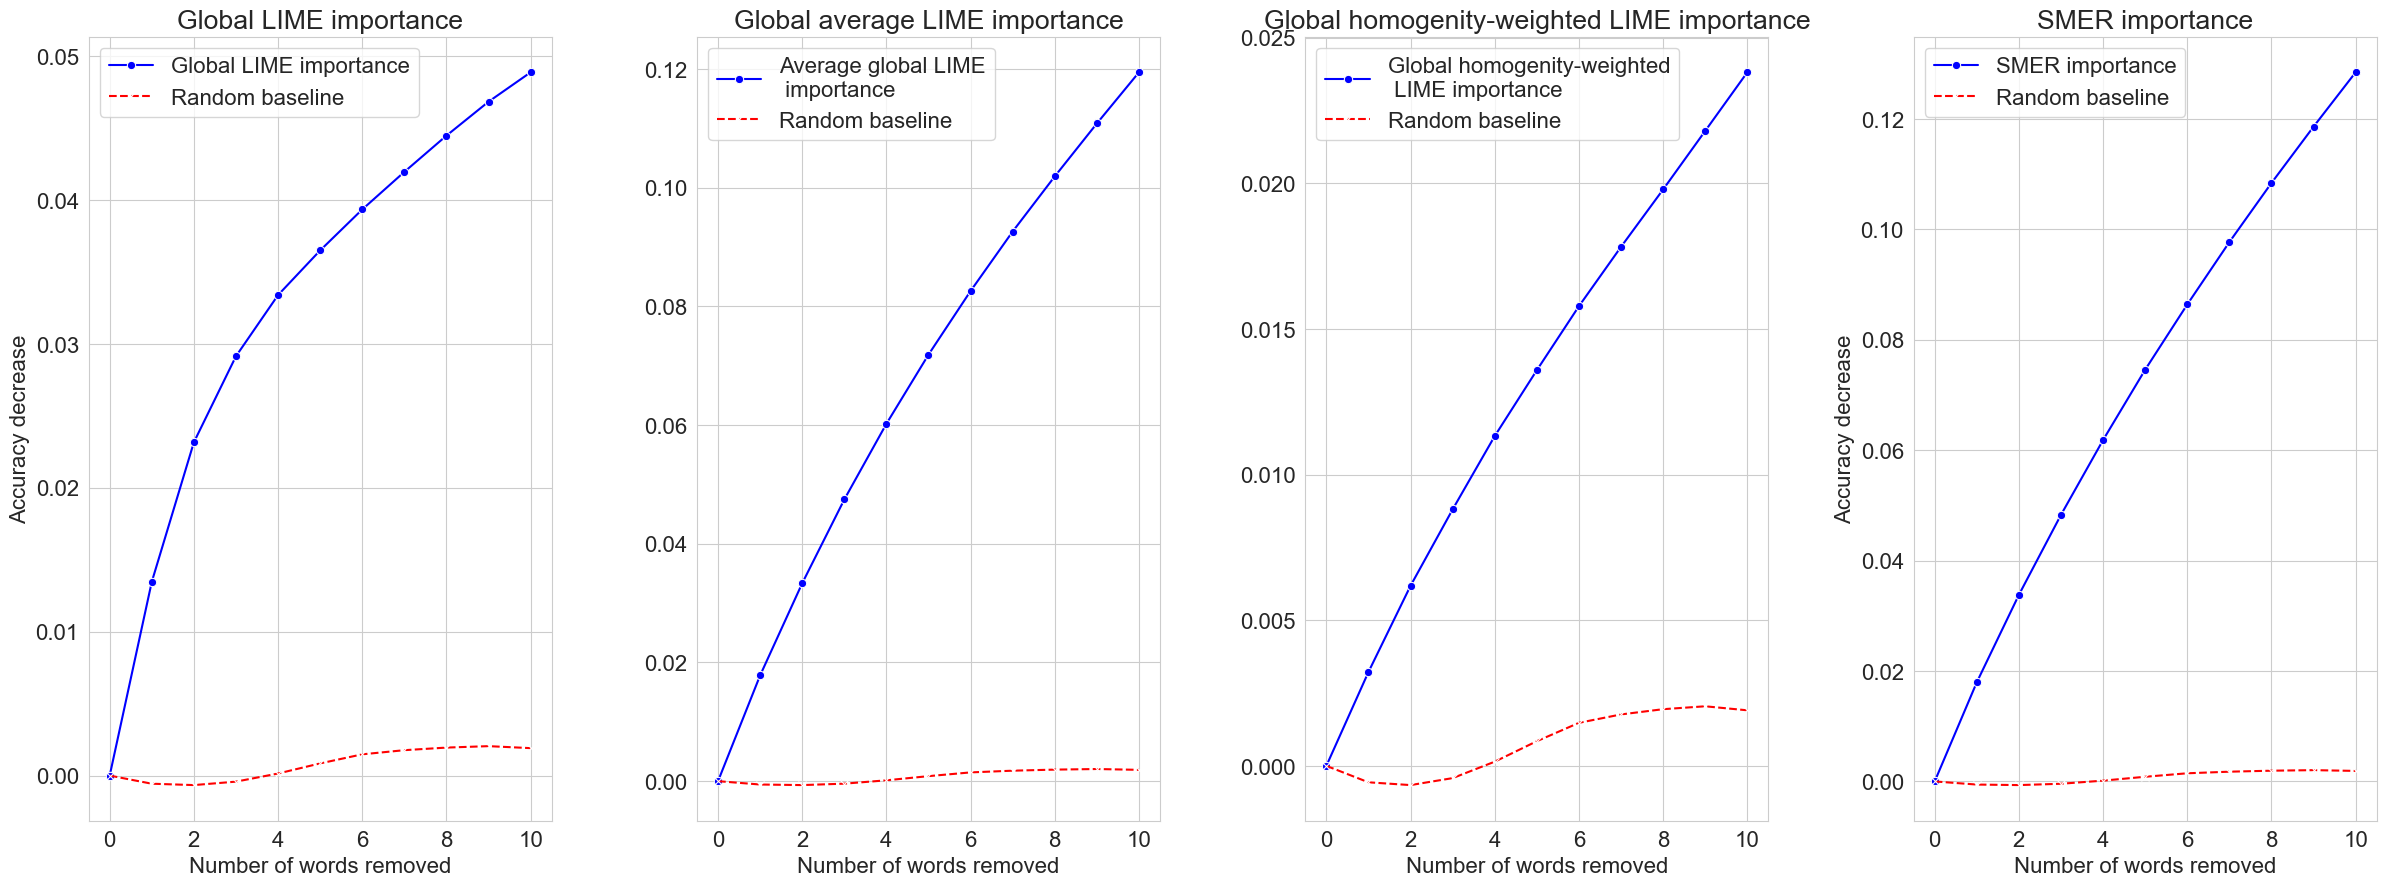

In [194]:
plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 16})

# function to plot accuracies with subplots
def plot_accuracies(ax, accuracies, accuracies_random, title, label, label_y_axis=False):
    sns.lineplot(x=range(len(accuracies)), y=accuracies, ax=ax, label=label, linestyle='-', marker='o', color='b')
    sns.lineplot(x=range(len(accuracies_random)), y=accuracies_random, ax=ax, label='Random baseline', linestyle='--', marker='x', color='r')
    
    ax.set_xlabel('Number of words removed')
    if label_y_axis:
        ax.set_ylabel('Accuracy decrease') 
    else:
        ax.set_ylabel('')
    ax.set_title(title)
    ax.legend()

sns.set_style("whitegrid")
# Create subplots
ax1 = plt.subplot(1, 4, 1)
plot_accuracies(ax1, df_results.AOPC_LIME, df_results.AOPC_RANDOM, 'Global LIME importance', 'Global LIME importance', label_y_axis=True)

ax2 = plt.subplot(1, 4, 2)
plot_accuracies(ax2, df_results.AOPC_AVG, df_results.AOPC_RANDOM, 'Global average LIME importance', 'Average global LIME\n importance')

ax3 = plt.subplot(1, 4, 3)
plot_accuracies(ax3, df_results.AOPC_HOMOGENEITY, df_results.AOPC_RANDOM, 'Global homogenity-weighted LIME importance', 'Global homogenity-weighted\n LIME importance')

ax4 = plt.subplot(1, 4, 4)
plot_accuracies(ax4, df_results.AOPC_SMER, df_results.AOPC_RANDOM, 'SMER importance', 'SMER importance', label_y_axis=True)
plt.tight_layout(pad=3.0)
plt.show()


## Plot all AOPCglobal curves

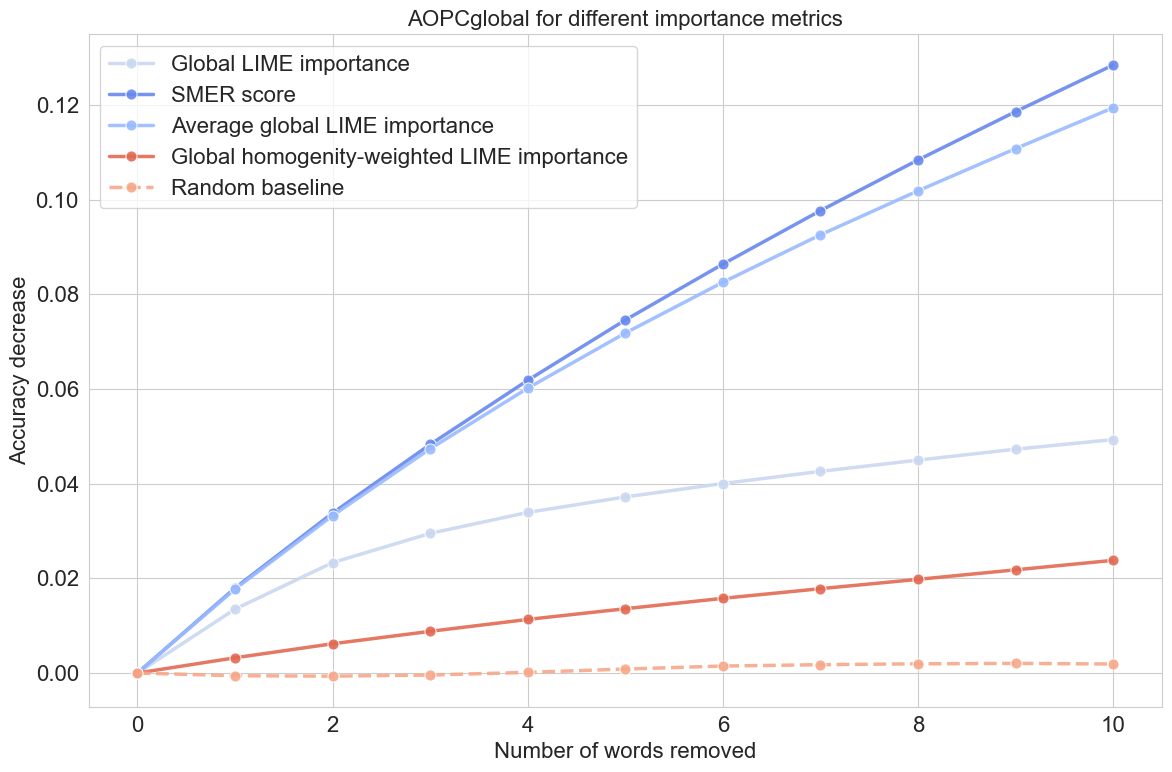

In [17]:
colors = sns.color_palette("coolwarm")

plt.figure(figsize=(12, 8))
def plot_AOPCglobal(ax, values, label, linestyle, marker, color):
    sns.lineplot(x=range(0, 11), y=values, ax=ax, label=label, linestyle=linestyle, marker=marker, color=color, linewidth=2.5, markersize=8, alpha=0.9)

sns.set_style("whitegrid")
ax = plt.gca()

# Plot AOPCglobal values for each metric and the random baseline using the colors from the 'colors' list
plot_AOPCglobal(ax, df_results.AOPC_LIME, 'Global LIME importance', '-', 'o', colors[2])
plot_AOPCglobal(ax, df_results.AOPC_SMER, 'SMER score', '-', 'o', colors[0])
plot_AOPCglobal(ax, df_results.AOPC_AVG, 'Average global LIME importance', '-', 'o', colors[1])
plot_AOPCglobal(ax, df_results.AOPC_HOMOGENEITY, 'Global homogenity-weighted LIME importance', '-', 'o', colors[5])
plot_AOPCglobal(ax, df_results.AOPC_RANDOM, 'Random baseline', '--', 'o', colors[4])

# Setting labels, title, and legend
ax.set_xlabel('Number of words removed', fontsize=16)
ax.set_ylabel('Accuracy decrease', fontsize=16)
ax.set_title('AOPCglobal for different importance metrics', fontsize=16)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=16)

plt.tight_layout()
plt.show()

## Merge LIME and SMER results

In [27]:
df_smer = pd.read_csv("SMER_word_score.csv").drop(columns=["Unnamed: 0"])
smer = pd.read_csv("SMER_output.csv").drop(columns=["Unnamed: 0"])
merged_smer = smer.merge(df_smer, on='word', how='left')

In [28]:
merged_df = pd.merge(merged_smer, df_word_metrics_no_duplicates, on="word", how="inner")

## Correlation of LIME to actual impact

In [29]:
merged_df = merged_df.rename(columns={"%_of_high_cit_x": "ActImpact"})

In [30]:
merged_df['global_avg_importance_scaled'] = scaler.fit_transform(merged_df["global_avg_importance"].values.reshape(-1, 1))

In [31]:
top_100_lime = merged_df.nlargest(100, 'global_avg_importance_scaled')
bottom_100_lime = merged_df.nsmallest(100, 'global_avg_importance_scaled')

combined_lime_avg_importance = pd.concat([top_100_lime, bottom_100_lime])

combined_lime_avg_importance[['word', 'ActImpact', 'global_avg_importance_scaled', "score"]].head()


,word,ActImpact,global_avg_importance_scaled,score
17041,phbs,1.000000,1.000000,0.029929
7127,circrnas,0.666667,0.973717,0.993478
14426,sgmrna,0.285714,0.944749,0.833685
8426,upregulate,0.421818,0.932137,0.890836
7261,please,0.558140,0.920330,0.964865


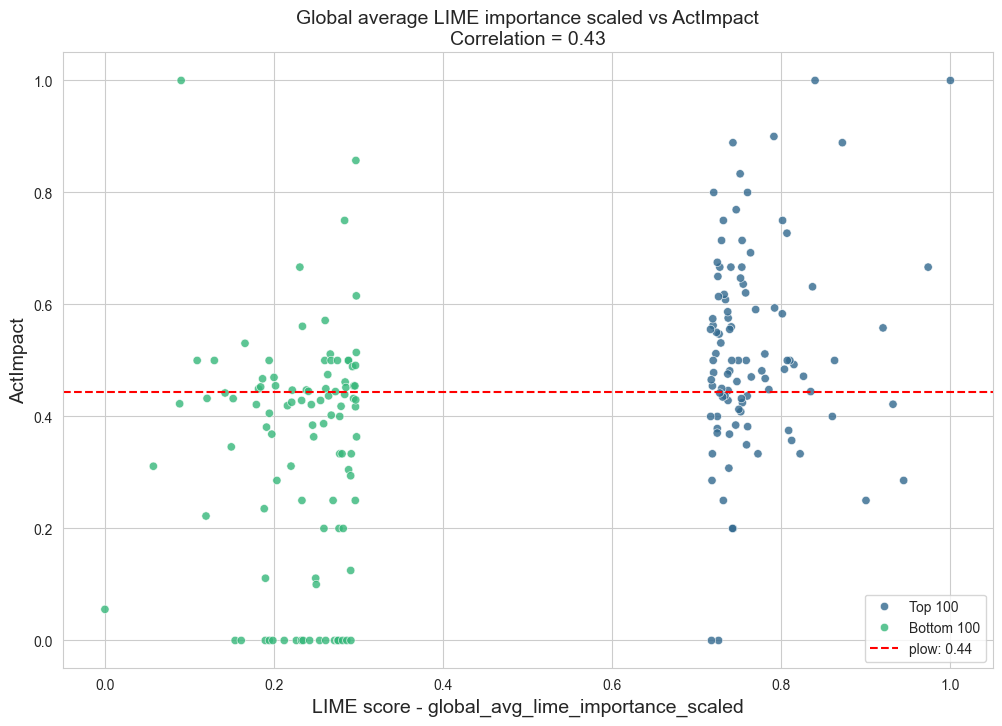

In [34]:
# Calculate Pearson correlation for LIME
corr_lime_avg_importance, _ = pearsonr(combined_lime_avg_importance["global_avg_importance_scaled"], combined_lime_avg_importance["ActImpact"])
plow = test_df[test_df.target == 1].shape[0] / test_df.shape[0]

# LIME Plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined_lime_avg_importance, x="global_avg_importance_scaled", y="ActImpact", hue=["Top 100"]*100 + ["Bottom 100"]*100, palette="viridis", alpha=0.8)
plt.axhline(plow, color="red", linestyle="--", label=f'plow: {plow:.2f}')
plt.title(f'Global average LIME importance scaled vs ActImpact\nCorrelation = {corr_lime_avg_importance:.2f}', fontsize=14)
plt.xlabel('LIME score - global_avg_lime_importance_scaled',  fontsize=14)
plt.ylabel('ActImpact', fontsize=14)
plt.legend()
plt.show()

## Correlation of LIME with SMER Score (top 100 highest and top 100 lowest ranked)

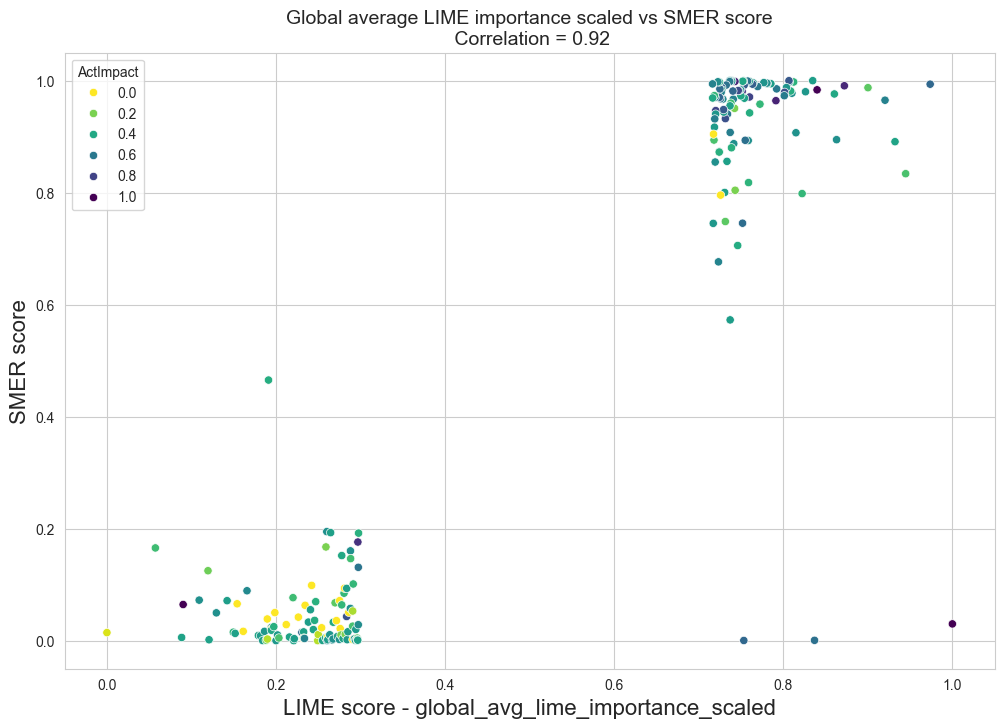

In [19]:
corr_coeff, _ = pearsonr(combined_lime_avg_importance['global_avg_importance_scaled'], combined_lime_avg_importance['score'])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined_lime_avg_importance, x="global_avg_importance_scaled", y="score", hue="ActImpact", palette="viridis_r", alpha=1)
plt.title(f"Global average LIME importance scaled vs SMER score\n Correlation = {corr_coeff:.2f}", fontsize=14)
plt.xlabel("LIME score - global_avg_lime_importance_scaled",  fontsize=16)
plt.ylabel("SMER score", fontsize=16)
plt.show()

## Correlation of LIME with SMER Score all words

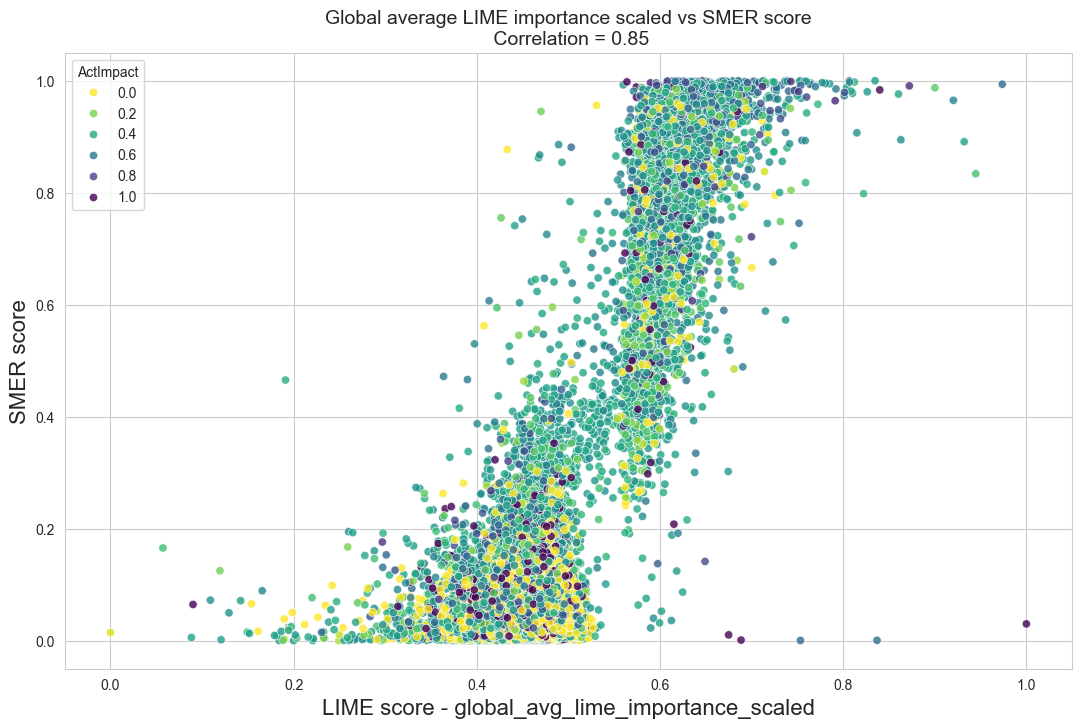

In [20]:
corr_coeff, _ = pearsonr(merged_df['global_avg_importance_scaled'], merged_df['score'])

plt.figure(figsize=(13, 8))
sns.set_palette(["#a6c4f7", "#e74c3c"])
sns.scatterplot(data=merged_df, x="global_avg_importance_scaled", y="score", alpha=0.8, hue="ActImpact", palette="viridis_r")
plt.title(f"Global average LIME importance scaled vs SMER score\n Correlation = {corr_coeff:.2f}", fontsize=14)
plt.xlabel("LIME score - global_avg_lime_importance_scaled",  fontsize=16)
plt.ylabel("SMER score", fontsize=16)
plt.show()

## Histogram of deviations between LIME and actual impact

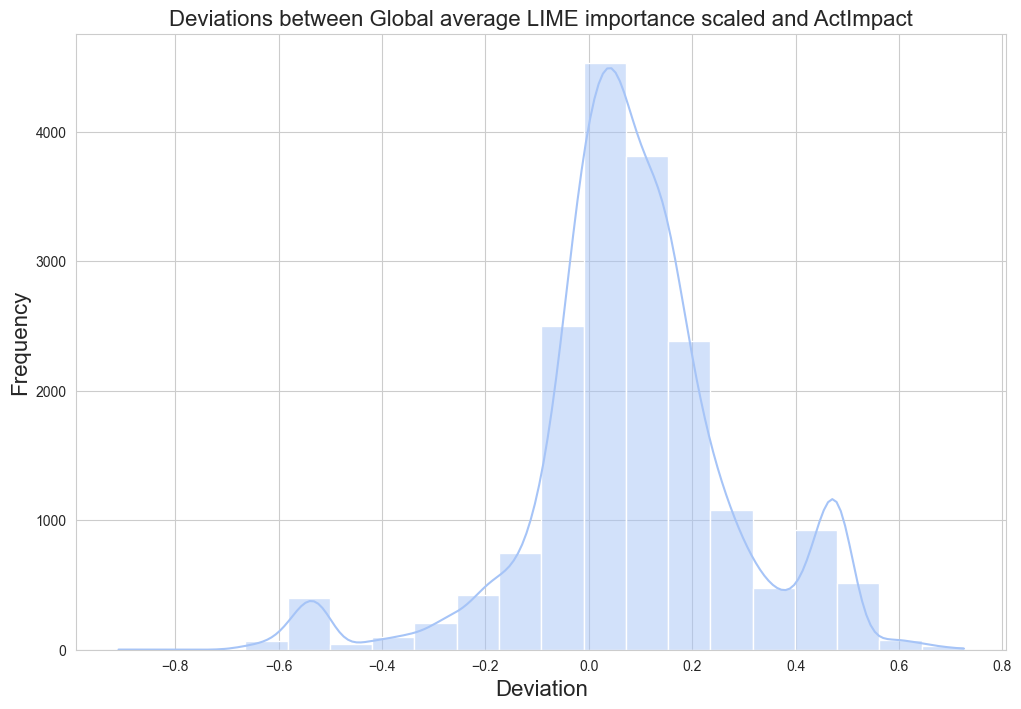

In [21]:
# Compute deviations
merged_df["deviation"] = merged_df["global_avg_importance_scaled"] - merged_df["ActImpact"]

# Plot histogram for deviations
plt.figure(figsize=(12, 8))
sns.histplot(merged_df["deviation"], kde=True, bins=20)
plt.title("Deviations between Global average LIME importance scaled and ActImpact", fontsize=16)
plt.xlabel("Deviation", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.show()


## Histogram of deviations between LIME and SMER Score

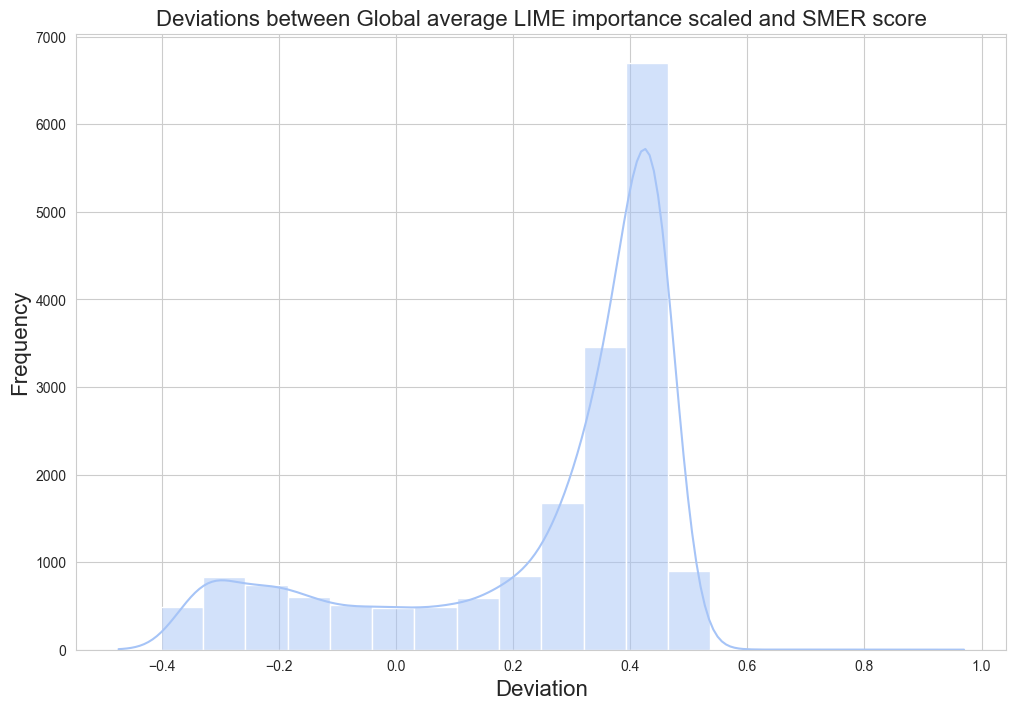

In [22]:
# Compute deviations
merged_df["deviation"] = merged_df["global_avg_importance_scaled"] - merged_df["score"]

# Plot histogram for deviations
plt.figure(figsize=(12, 8))
sns.histplot(merged_df["deviation"], kde=True, bins=20)
plt.title("Deviations between Global average LIME importance scaled and SMER score", fontsize=16)
plt.xlabel("Deviation", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.show()


## Identify smallest and highest deviations between LIME and actual impact

In [26]:
# Getting words with smallest deviations (close to zero)
close_to_zero = merged_df.iloc[(merged_df['deviation']-0).abs().argsort()[:10]]
# Getting words with largest positive deviations
largest_positive = merged_df.nlargest(10, 'deviation')
# Getting words with largest negative deviations
largest_negative = merged_df.nsmallest(10, 'deviation')

In [28]:
close_to_zero[["word", "score", "global_avg_importance_scaled", 'deviation']]

,word,score,global_avg_importance_scaled,deviation
4648,psychometric,0.593170,0.593159,-0.000011
2653,racial,0.593527,0.593455,-0.000072
5244,hybridization,0.611357,0.611600,0.000243
862,tract,0.584326,0.583988,-0.000337
4972,25ohd,0.591528,0.591148,-0.000380
12143,sequencer,0.630560,0.631063,0.000503
6302,aggravate,0.509052,0.509614,0.000562
13941,threonine,0.622638,0.622012,-0.000625
9784,perk,0.581219,0.581855,0.000635
4207,kawasaki,0.621038,0.621804,0.000766


## Find inconsistencies between Local and Global metrics

In [78]:
lime_df_word_metrics_merged = pd.merge(lime_df_word_metrics, df_smer[['word', 'score']], on='word', how='left')

In [49]:
lime_df_word_metrics_merged = pd.read_csv("word_metrics_merged.csv")

In [81]:
lime_df_word_metrics_merged = lime_df_word_metrics_merged.rename(columns={"importance": "importance_norm"})

In [52]:
def find_all_inconsistencies(df, global_importance_col, threshold_deviation=0.1):
    inconsistent_indices = []

    for word in df['word'].unique():
        word_df = df[df['word'] == word]
        deviations = abs(word_df['importance'] - word_df[global_importance_col].iloc[0])
        inconsistent_rows = word_df[deviations > threshold_deviation]
        inconsistent_indices.extend(inconsistent_rows.index.tolist())

    return df.loc[inconsistent_indices][["word", "importance", "abstract_text", global_importance_col, "doi", "score"]]

inconsistent_rows = find_all_inconsistencies(lime_df_word_metrics_merged, 'global_avg_importance')

inconsistent_rows["abstract_text_len"] = inconsistent_rows.abstract_text.apply(lambda x: len(x.split()))
inconsistent_rows['importance_diff'] = (inconsistent_rows['importance'] - inconsistent_rows['global_avg_importance']).round(3)
inconsistent_rows["importance_diff_abs"] = inconsistent_rows["importance_diff"].abs()

In [53]:
print(f"Number of words: {inconsistent_rows.shape[0]}")
inconsistent_rows.sort_values("importance_diff_abs", ascending=False).head()

Number of words: 247


,word,importance,abstract_text,global_avg_importance,doi,score,abstract_text_len,importance_diff,importance_diff_abs
296196,epidemic,0.070000,preventing dengue epidemic covid-19 pandemic,0.513166,10.4269/ajtmh.20-0480,0.967001,5,-0.443,0.443
107605,tuberculosis,0.109221,covid-19 tuberculosis,0.480093,10.1183/13993003.02710-2020,0.000380,2,-0.371,0.371
572297,registered,0.265893,chictr registered february 2020 - retrospectiv...,0.487105,10.1186/s13054-020-03007-0,0.008302,7,-0.221,0.221
163689,incident,0.301084,incident sars-cov-2 infection shared latrine,0.484868,10.4269/ajtmh.20-0793,0.000960,5,-0.184,0.184
414259,see,0.301949,see article page issue,0.484925,10.1111/trf.15831,0.058852,4,-0.183,0.183


In [ ]:
inconsistent_rows['importance_diff'] = (inconsistent_rows['importance_norm'] - inconsistent_rows['global_avg_importance']).round(2)
inconsistent_rows['color'] = inconsistent_rows['importance_diff'].apply(lambda x: 'red' if x >= 0 else 'blue')

# Create scatter plot
fig = px.scatter(
    inconsistent_rows,
    x='importance',
    y='global_avg_importance',
    size='abstract_text_len',
    color='color',
    color_discrete_map={"red": "#ff7f0e", "blue": "#1f77b4"},
    hover_data={
        'importance_diff': True,
        'doi': True,
        'word': True,
        'score': True,
        'importance': True,
        'global_avg_importance': True,
        'abstract_text_len': False
    }
)

min_value = min(inconsistent_rows['importance_norm'].min(), inconsistent_rows['global_avg_importance'].min())
max_value = max(inconsistent_rows['importance_norm'].max(), inconsistent_rows['global_avg_importance'].max())

# Add line of perfect correlation
fig.add_trace(
    go.Scatter(x=[min_value, max_value], y=[min_value, max_value], mode='lines', line=dict(color='darkgrey', width=1))
)

# Boundary Area
fig.add_trace(
    go.Scatter(
        x=[min_value, max_value, max_value, min_value, min_value],
        y=[min_value - 0.1, max_value - 0.1, max_value + 0.1, min_value + 0.1, min_value - 0.1],
        fill='toself',
        fillcolor='rgba(220, 220, 220, 0.4)',
        mode='lines',
        line=dict(color='rgba(220, 220, 220, 0)'),
        name='Boundary area (+/- 0.1)'
    )
)

# Updating hover template and layout
fig.update_traces(
    hovertemplate='<br>'.join([
        'Importance: %{x:.2f}',
        'Global average LIME importance: %{y:.2f}',
        'Importance Diff: %{customdata[0]}',
        'DOI: %{customdata[1]}',
        'Word: %{customdata[2]}',
        'Score: %{customdata[3]:.2f}',
        'Abstract Length: %{marker.size}'
    ])
)

fig.update_layout(
    title={
        'text': 'Local vs global average LIME importance',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}
    },
    showlegend=False,
    xaxis_title='Local LIME importance',
    yaxis_title='Global average LIME importance',
    xaxis=dict(range=[min_value, max_value]),
    yaxis=dict(range=[min_value, max_value]),
    height=800,
    width=1200,
    plot_bgcolor='white'
)

fig.update_xaxes(
    title_text='Local LIME Importance',
    title_font=dict(size=18),
    showgrid=True,
    gridcolor='#f0f0f0',
    gridwidth=0.5
)

fig.update_yaxes(
    title_text='Global Average LIME Importance',
    title_font=dict(size=18),
    showgrid=True,
    gridcolor='#f0f0f0',
    gridwidth=0.5
)

fig.update_traces(
    hoverlabel=dict(
        namelength=-1,
        font_size=16
    )
)

fig.show()

In [88]:
def fetch_abstract_by_doi(doi, df):
    if 'abstract_text' not in df.columns:
        raise ValueError("DataFrame does not contain 'abstract_text' column.")
    result = df[df['doi'] == doi]['abstract_text']
    if result.empty:
        raise ValueError(f"No record found for DOI: {doi}")

    return result.iloc[0]


def colorize_importance(importance, rank, decrease_amount=0.05, max_alpha=1.0):
    if importance > 0.5:
        alpha = max_alpha - rank * decrease_amount
        return f'rgba(255, 164, 56, {alpha})'
    else:
        alpha = max_alpha - rank * decrease_amount
        return f'rgba(135, 180, 250, {alpha})'


def colorize_importance_stacked_plot(importance, rank, decrease_amount=0.05, max_alpha=1.0):
    orange = (1.0, 140/255, 0)
    light_blue = (135/255, 206/255, 250/255)
    alpha = max_alpha - rank * decrease_amount
    alpha = max(0, alpha)
    return (orange + (alpha,)) if importance > 0 else (light_blue + (alpha,))


def colorize_importance_plot(importance, rank, total_ranks, decrease_amount=0.1, max_alpha=1.0, min_alpha=0.2):
    orange = (255, 140, 0) 
    light_blue = (135, 206, 250) 
    alpha = max_alpha - ((total_ranks - rank) * decrease_amount)
    alpha = min(max(alpha, min_alpha), max_alpha)
    orange_scaled = tuple([o / 255 for o in orange]) + (alpha,)
    light_blue_scaled = tuple([lb / 255 for lb in light_blue]) + (alpha,)

    return orange_scaled if importance > 0.5 else light_blue_scaled


def highlight_abstract_words(abstract, words_df):
    # Sort the words by importance so the most important words are highlighted first.
    words_df = words_df.sort_values(by='final_importance', ascending=False)

    for idx, (_, row) in enumerate(words_df.iterrows()):
        importance = row['final_importance']
        word = re.escape(row['word'])
        hue = colorize_importance(importance, rank=idx)
        text_color = 'white' if importance < 0.5 else 'black'
        
        def replacement_func(match):
            whole_word_match = rf'\b{match.group()}\b'
            if re.fullmatch(whole_word_match, match.group()):
                return f'<span style="background-color:{hue}; color:{text_color};">{match.group()}</span>'
            else:
                return match.group()
        
        pattern = rf'\b{word}\b'
        compiled_pattern = re.compile(pattern, re.IGNORECASE)
        abstract = compiled_pattern.sub(replacement_func, abstract)
    
    return abstract
    
def determine_importance(doi, df, global_importance_col, threshold, use_smer=False):
    subset = df[df['doi'] == doi].copy()
    if use_smer:
        subset['final_importance'] = np.where(
        abs(subset['importance_scaled'] - subset["score"]) < 0.4,
        subset["score"],
        subset['importance_scaled']
    )
    else:
        subset['final_importance'] = np.where(
            abs(subset['importance_norm'] - subset[global_importance_col]) < threshold,
            subset[global_importance_col],
            subset['importance_norm']
        )
    return subset


def plot_stacked_importance_chart(df, use_smer=False):
    sns.set_style("whitegrid")
    
    # Determine sorting column and calculate differences
    sort_by_col = 'smer_score' if use_smer else 'global_importance'
    df['base_importance'] = df[sort_by_col] - 0.5
    df['difference'] = df['local_importance'] - df[sort_by_col]
    df['local_shifted'] = df['local_importance'] - 0.5
    df['rank'] = df['base_importance'].abs().rank(method='first', ascending=False)
    df = df.sort_values('rank', ascending=True)

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, len(df)))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    #fig.patch.set_alpha(0)
    ax.set_frame_on(False)
    df.set_index('word', inplace=True)

    ax.barh(df.index, df['base_importance'], left=0.5, color='grey', edgecolor='none', alpha=0.9)

    for idx, (word, row) in enumerate(df.iterrows()):
        rank = row['rank']
        color = colorize_importance_stacked_plot(row['difference'], rank)
        global_bar_value = row['base_importance']
        local_bar_value = row['local_shifted']
        global_bar_end = 0.5 + global_bar_value
        local_bar_end = 0.5 + local_bar_value
        
        if abs(global_bar_value) > abs(local_bar_value):
            ax.barh(word, global_bar_value, left=0.5, color='grey', edgecolor='none', alpha=0.9)
            ax.barh(word, local_bar_value, left=0.5, color=color, edgecolor='none', alpha=0.9)
        else:
            ax.barh(word, local_bar_value, left=0.5, color=color, edgecolor='none', alpha=0.9)
            ax.barh(word, global_bar_value, left=0.5, color='grey', edgecolor='none', alpha=0.9)

        
        if abs(global_bar_end - 0.5) > abs(local_bar_end - 0.5):
            label_x_position = global_bar_end
        else:
            label_x_position = local_bar_end

        if label_x_position < 0.5:
            text_align = 'right'
            label_padding = -0.001
        else:
            text_align = 'left'
            label_padding = 0.001

        # Place the word label
        ax.text(label_x_position + label_padding, idx - 0.2, word, va='center', ha=text_align, color='black', fontsize=18)
        # Place the global and local value labels
        text = f'Global: {global_bar_value + 0.5:.2f}, Local: {local_bar_value + 0.5:.2f}'
        ax.text(label_x_position + label_padding, idx + 0.2, text, va='center', ha=text_align, color='grey', fontsize=14)
    
    ax.set_title(f'Global {"SMER" if use_smer else "LIME"} importance vs rescaled local LIME importance', fontsize=16, fontweight='bold', color="black")
    global_patch = mpatches.Patch(color='grey', label=f"Global{' SMER' if use_smer else ' LIME'} importance")
    local_smaller_patch = mpatches.Patch(color='lightblue', label='Local importance smaller than global')
    local_bigger_patch = mpatches.Patch(color='orange', label='Local importance bigger than global')
    ax.legend(handles=[global_patch, local_smaller_patch, local_bigger_patch], loc='best', fontsize=13)
    max_importance = max(df['base_importance'].abs().max(), df['local_shifted'].abs().max())
    x_min = 0.5 - max_importance - 0.05
    x_max = 0.5 + max_importance + 0.05
    ax.set_xlim([x_min, x_max])
    ax.axvline(x=0.5, color='gray', linewidth=1, linestyle='-')
    plt.gca().invert_yaxis() 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([0.5])
    ax.set_xticklabels(['0.5'], fontsize=12, color='grey')

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=150, transparent=True)
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')

    return f'<img src="data:image/png;base64,{img_base64}" alt="Bar chart"/>'


def display_stacked_importance_chart(doi, df, use_smer=False, threshold=0.1, global_importance_col="global_avg_importance"):
    relevant_words_df = determine_importance(doi, df, global_importance_col, threshold, use_smer)
    if use_smer:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['score'] - 0.5)
    else:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['final_importance'] - 0.5)
    
    relevant_words_df = relevant_words_df.sort_values(by='distance_from_center', ascending=False)
    data_for_plot = pd.DataFrame([
        {
            "word": row['word'],
            "global_importance": row[f"{global_importance_col}_scaled"] if use_smer else row[global_importance_col],
            "local_importance": row["importance_scaled"] if use_smer else row["importance_norm"],
            "smer_score": row['score']
        }
        for _, row in relevant_words_df.iterrows()
    ])
    img_html_lime = plot_stacked_importance_chart(data_for_plot, use_smer)
    display(HTML(f"""
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 1000px; word-wrap: break-word; overflow-y: auto;'>
                {img_html_lime}
            </div>
        </div>
    """))


def compute_word_scores_for_abstract(abstract, df, column='score', top_n=15):
    words = pd.Series(abstract.split()).unique()
    word_scores = []

    for word in words:
        scores = df[df['word'] == word][column].unique()
        if scores.size > 0:
            average_score = np.mean(scores)
            word_scores.append((word, average_score, abs(average_score - 0.5)))

    sorted_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(sorted_words, columns=['word', "final_importance", 'distance_from_center'])


def compute_word_scores_for_abstract(abstract, df, column='score', top_n=15, absolute=False):
    words = pd.Series(abstract.split()).unique()
    word_scores = []

    for word in words:
        scores = df[df['word'] == word][column].unique()
        if scores.size > 0:
            average_score = np.mean(scores)
            word_scores.append((word, average_score, abs(average_score - 0.5)))

    if absolute:
        sorted_words = sorted(word_scores, key=lambda x: abs(x[1] - 0.5))
        half_n = top_n // 2
        final_words = sorted_words[:half_n] + sorted_words[-half_n:]
    else:
        final_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]

    return pd.DataFrame(final_words, columns=['word', "final_importance", 'distance_from_center'])


def colorize_importance_bar_plots(importance, rank, total_ranks, max_alpha=1.0):
    orange = (255/255, 140/255, 0)
    light_blue = (135/255, 180/255, 250/255)
    alpha_scale = rank / total_ranks
    alpha = max_alpha * max((rank / total_ranks), 0.2)

    return (orange + (alpha,)) if importance > 0.5 else (light_blue + (alpha,))

    

def plot_importance_bar_chart(data, use_smer=False, include_smer_scores=False, threshold=0.1):
    sns.set_style("white")
    if use_smer:
        data = [item for item in data if np.isfinite(item['smer_score'])]
    else:
        data = [item for item in data if np.isfinite(item['final_importance'])]

    data = data[::-1]
    words = [item['word'] for item in data]
    importance = [item['smer_score'] if use_smer else item['final_importance'] for item in data]
    importance_shifted = [(value - 0.5) for value in importance]

    fig, ax = plt.subplots(figsize=(6, len(data) * 0.8))
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    bar_colors = [colorize_importance_plot(value, idx, len(data) - 1) for idx, value in enumerate(importance)]
    bars = ax.barh(words, importance_shifted, color=bar_colors, edgecolor='none')
    for bar in bars:
        bar.set_linewidth(0.5)

    for index, value in enumerate(importance_shifted):
        word_label = words[index]
        local_metric = f'{value + 0.5:.3f}'
        global_metric = f'{data[index]["global_importance"]:.3f}'

        if use_smer:
            diff = abs(data[index]["local_importance"] - data[index]["smer_score"]) > 0.4
            importance_label = f'SMER: {importance[index]:.3f}' + (f' LIME: {data[index]["local_importance"]:.3f}' if diff else "")
        else:
            diff = abs(data[index]["local_importance"] - data[index]["global_importance"]) > threshold
            importance_label = f"{'LIME' if diff else 'GLIME'}: {local_metric}"
            if diff:
                importance_label += f" (GLIME: {global_metric})"

        if include_smer_scores and not use_smer:
            importance_label += f' SMER: {data[index]["smer_score"]:.3f}'
        # Display the word
        ha_position = 'right' if value < 0 else 'left'
        ax.text(value - 0.005 if value < 0 else value + 0.005, index + 0.2, word_label, color='black', va='center', ha=ha_position, fontsize=18, fontweight='bold')
        # Display the importance value
        label_color = 'red' if diff else 'grey'
        ax.text(value - 0.005 if value < 0 else value + 0.005, index - 0.2, importance_label, color=label_color, va='center', ha=ha_position, fontsize=14)


    max_shift_abs = abs(max(importance_shifted, key=abs))
    padding = 0.1
    ax.set_xlim(-max_shift_abs - padding, max_shift_abs + padding)
    ax.axvline(0, color='grey', lw=1)
    ax.set_xticks([0])
    ax.set_xticklabels(['0.5'], fontsize=12, color='grey')

    high_cited_handle = mpatches.Patch(color=colorize_importance_plot(1, 14, len(data)), label='High cited')
    low_cited_handle = mpatches.Patch(color=colorize_importance_plot(0, 14, len(data)), label='Low cited')

    ax.legend(handles=[high_cited_handle, low_cited_handle], loc='best', fontsize=12)
    title_text = ('Rescaled word importance' if not use_smer else 'Word importance')  + (' SMER' if use_smer else ' LIME') + (' with SMER Scores' if include_smer_scores and not use_smer else '')
    ax.set_title(title_text, fontsize=16, fontweight='bold', y=1.02, color='black')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])

    # Save the figure into an image buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=150)
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')

    return f'<img src="data:image/png;base64,{img_base64}" alt="Bar chart"/>'


    
def plot_importance_bar_charts_with_smer(data, use_smer=False):
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(6, len(data) * 0.8))
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    importance_shifted_values = []
    for index, item in enumerate(data):
        word = item['word']
        importance = item['final_importance']
        importance_shifted = importance - 0.5
        importance_shifted_values.append(importance_shifted)
        # Determine color based on importance
        color = colorize_importance_bar_plots(importance, index, len(data) - 1)

        # Adjust bar position
        bar_position = 0.5 if importance_shifted > 0 else 0.5 + importance_shifted
        ax.barh(word, abs(importance_shifted), left=bar_position, color=color, edgecolor='none')

        # Adjust text positioning and padding
        label_x_padding = 0.005
        label_x_position = (0.5 + importance_shifted + label_x_padding) if importance_shifted > 0 else (0.5 + importance_shifted - label_x_padding)
        ha_position = 'left' if importance_shifted > 0 else 'right'

        # Display the word and importance value
        ax.text(label_x_position, index + 0.2, f"{word}", va='center', ha=ha_position, fontsize=18, color='black', fontweight='bold')
        ax.text(label_x_position, index - 0.2, f"{importance:.2f}", va='center', ha=ha_position, fontsize=18, color='grey')

    high_cited_handle = mpatches.Patch(color=colorize_importance_bar_plots(1, 14, len(data)), label='High cited')
    low_cited_handle = mpatches.Patch(color=colorize_importance_bar_plots(0, 14, len(data)), label='Low cited')
    ax.legend(handles=[high_cited_handle, low_cited_handle], loc='upper left', fontsize=12)

    max_shift_abs = abs(max(importance_shifted_values, key=abs))
    padding = 0.1
    ax.set_xlim(0.5 - max_shift_abs - padding, 0.5 + max_shift_abs + padding)
    ax.axvline(0.5, color='grey', lw=1)
    ax.set_xticks([0.5])
    ax.set_xticklabels(['0.5'], fontsize=12, color='grey')
    ax.set_title('Global word importance' + f"{' SMER' if use_smer else ' LIME'}", fontsize=16, fontweight='bold', color='black')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])

    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=150)
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')

    return f'<img src="data:image/png;base64,{img_base64}" alt="Bar chart"/>'


def display_plots_with_abstract(doi, df, global_importance_col="global_avg_importance_scaled", absolute=False):
    abstract = fetch_abstract_by_doi(doi, df)
    
    # LIME
    lime_words_df = compute_word_scores_for_abstract(abstract, df, column=global_importance_col, absolute=absolute)
    lime_words_df = lime_words_df.sort_values(by='final_importance')
    highlighted_abstract_lime = highlight_abstract_words(abstract, lime_words_df)
    img_html_lime = plot_importance_bar_charts_with_smer(lime_words_df.to_dict(orient='records'))

    # SMER
    smer_words_df = compute_word_scores_for_abstract(abstract, df, column='score', absolute=absolute)
    smer_words_df = smer_words_df.sort_values(by='final_importance')
    highlighted_abstract_smer = highlight_abstract_words(abstract, smer_words_df)
    img_html_smer = plot_importance_bar_charts_with_smer(smer_words_df.to_dict(orient='records'), use_smer=True)

    display(HTML(f"""
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 600px; word-wrap: break-word; overflow-y: auto;'>
                {img_html_lime}
            </div>
            <div style='flex: 3; padding: 10px; padding-top: 20px; max-width: 800px; word-wrap: break-word; font-size: 1.2em;'>
                <h2>Explained instance</h2>
                <h4> DOI: {doi}</h4>
                {highlighted_abstract_lime}
            </div>
        </div>
        </br>
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 600px; word-wrap: break-word; overflow-y: auto;'>
                {img_html_smer}
            </div>
            <div style='flex: 3; padding: 10px; padding-top: 20px; max-width: 800px; word-wrap: break-word; font-size: 1.2em;'>
                <h2>Explained instance</h2>
                <h4> DOI: {doi}</h4>
                {highlighted_abstract_smer}
            </div>
        </div>
    """))


def display_abstract_with_highlights(doi, df, use_smer=False, threshold=0.1, include_smer_scores=False, global_importance_col="global_avg_importance"):
    abstract = fetch_abstract_by_doi(doi, df)
    relevant_words_df = determine_importance(doi, df, global_importance_col, threshold, use_smer)
    if use_smer:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['score'] - 0.5)
    else:
        relevant_words_df['distance_from_center'] = abs(relevant_words_df['final_importance'] - 0.5)
    
    relevant_words_df = relevant_words_df.sort_values(by='distance_from_center', ascending=False)
    highlighted_abstract = highlight_abstract_words(abstract, relevant_words_df)
    data_for_plot = [
    {
        "word": row['word'],
        "final_importance": row['final_importance'],
        "global_importance": row[f"{global_importance_col}_scaled"] if use_smer else row[global_importance_col],
        "local_importance": row["importance_scaled"] if use_smer else row["importance_norm"],
        "smer_score": row['score']
    }
    for _, row in relevant_words_df.iterrows()
]
    img_html = plot_importance_bar_chart(data_for_plot, use_smer, include_smer_scores, threshold)

    display(HTML(f"""
        <div style='display: flex; justify-content: center; align-items: center;'>
            <div style='flex: 2; padding: 10px; max-width: 700px; word-wrap: break-word; overflow-y: auto;'>
                {img_html}
            </div>
            <div style='flex: 3; padding: 10px; padding-top: 20px; max-width: 800px; word-wrap: break-word; font-size: 1.2em;'>
                <h2>Explained instance</h2>
                <h4> DOI: {doi}</h4>
                {highlighted_abstract}
            </div>
        </div>
    """))


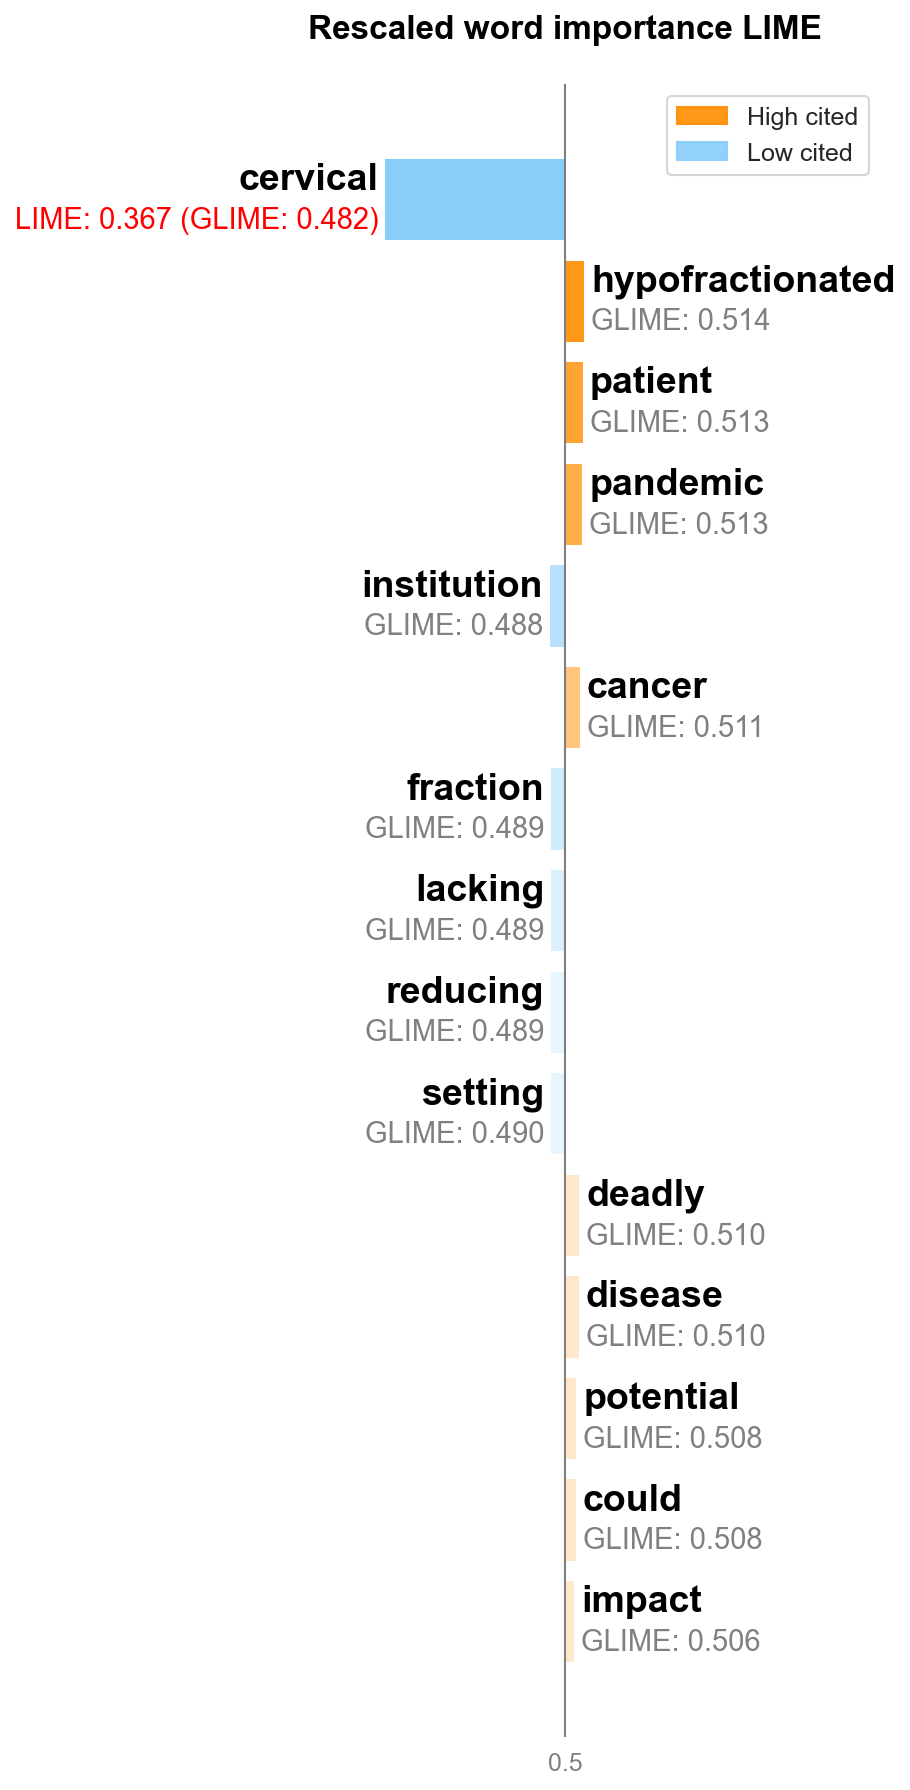

In [89]:
# insert doi of abstarct
doi_of_interest = "10.1016/j.radonc.2020.05.032"
include_smer_scores = False
threshold = 0.1
use_smer = False

display_abstract_with_highlights(doi_of_interest, lime_df_word_metrics_merged, use_smer, threshold, include_smer_scores)


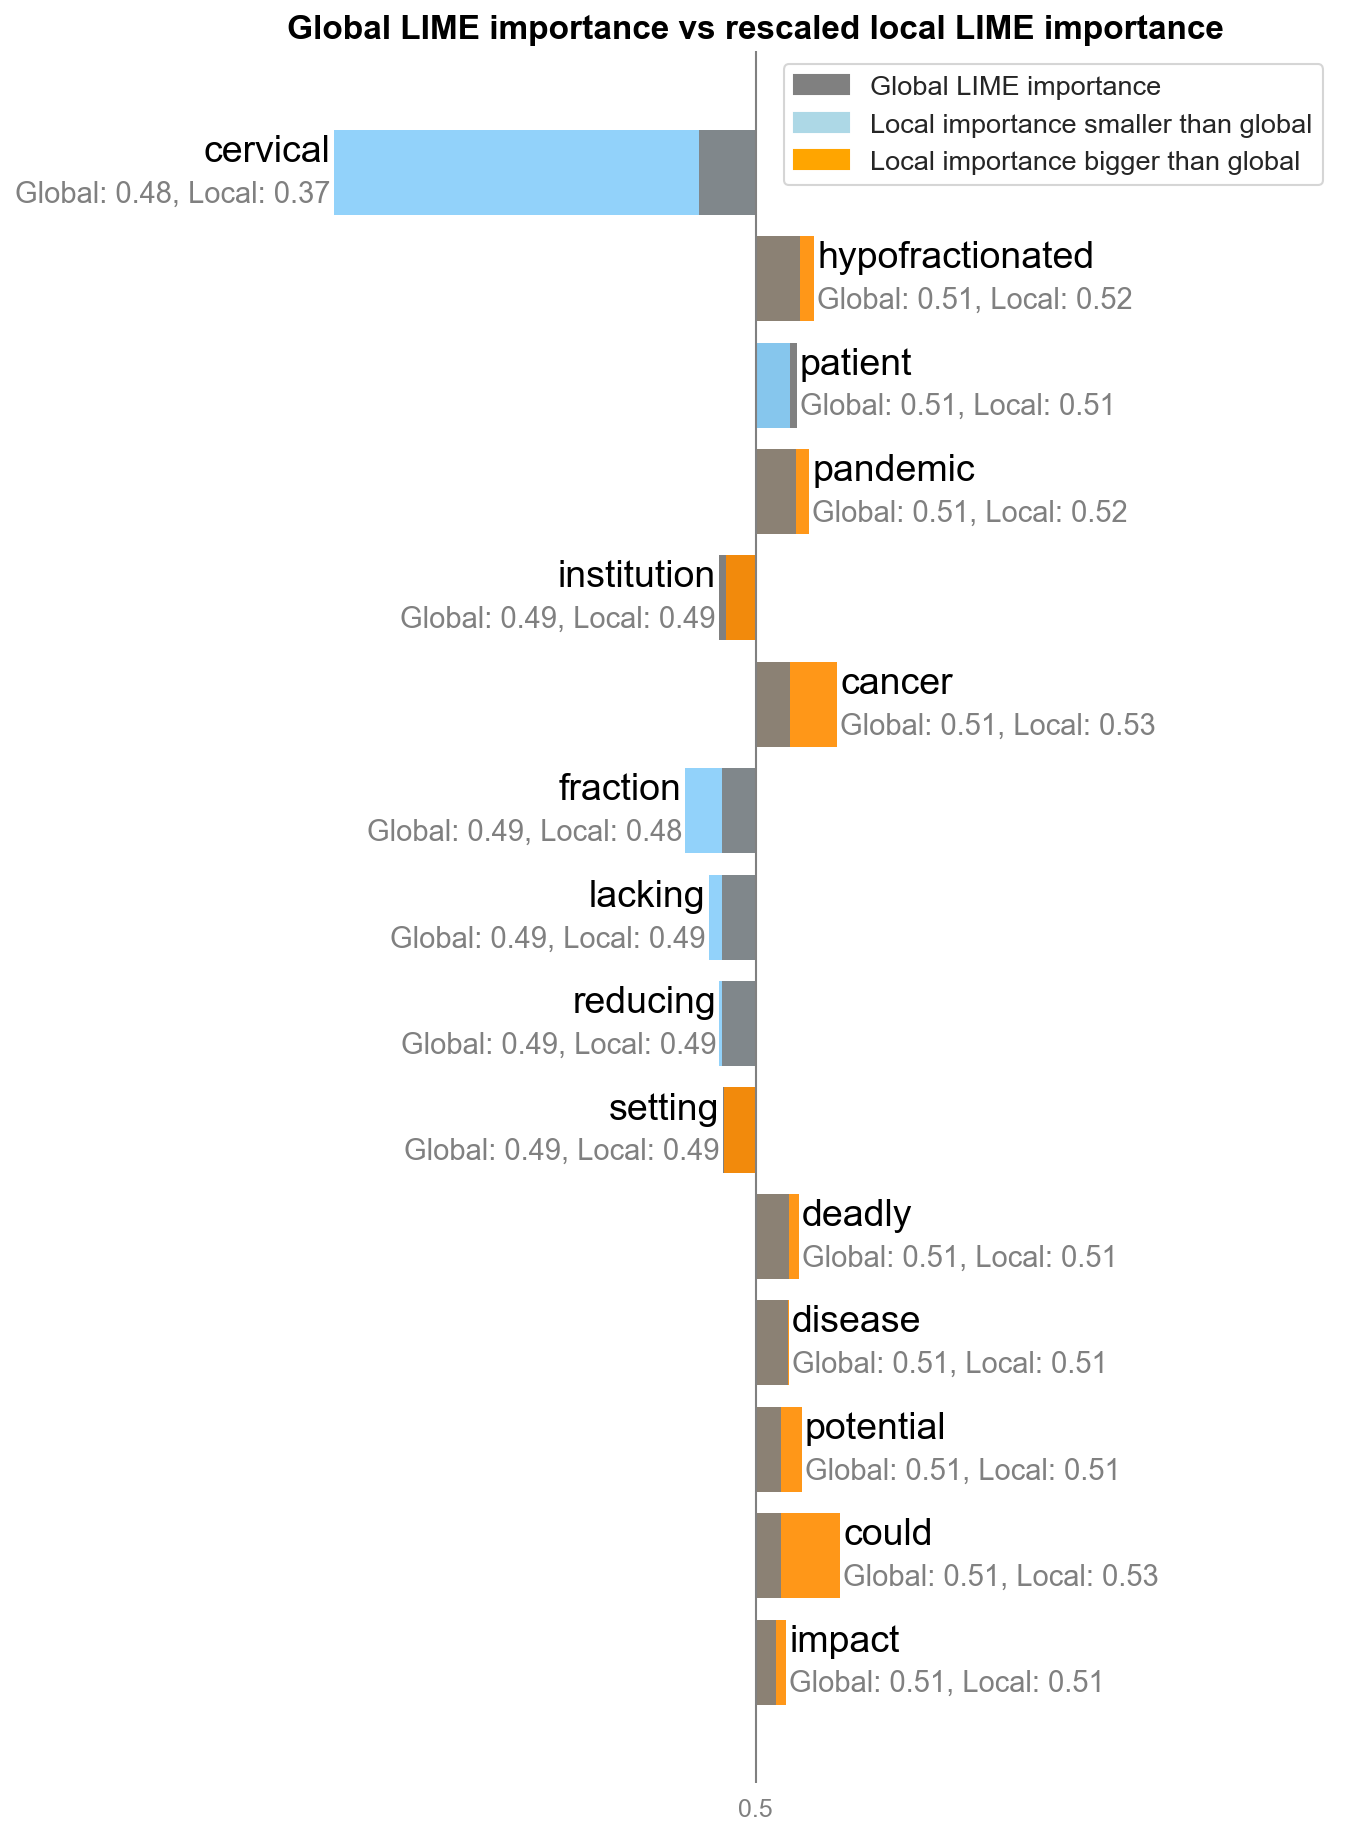

In [90]:
doi_of_interest = "10.1016/j.radonc.2020.05.032"
use_smer = False

display_stacked_importance_chart(doi_of_interest, lime_df_word_metrics_merged, use_smer)


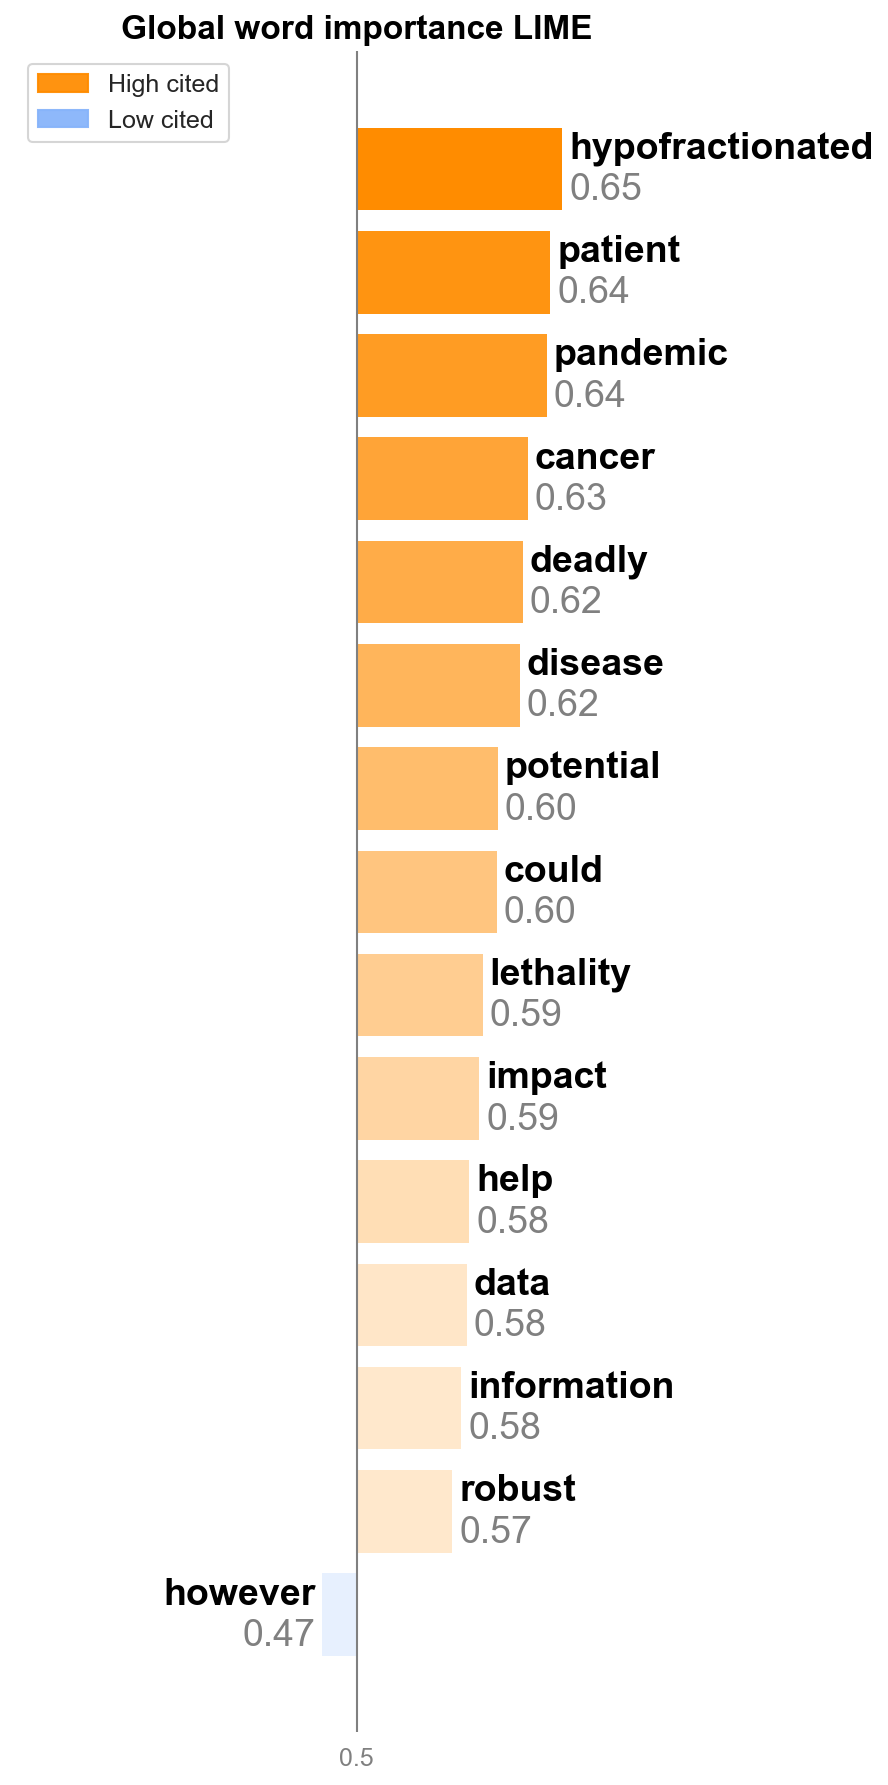
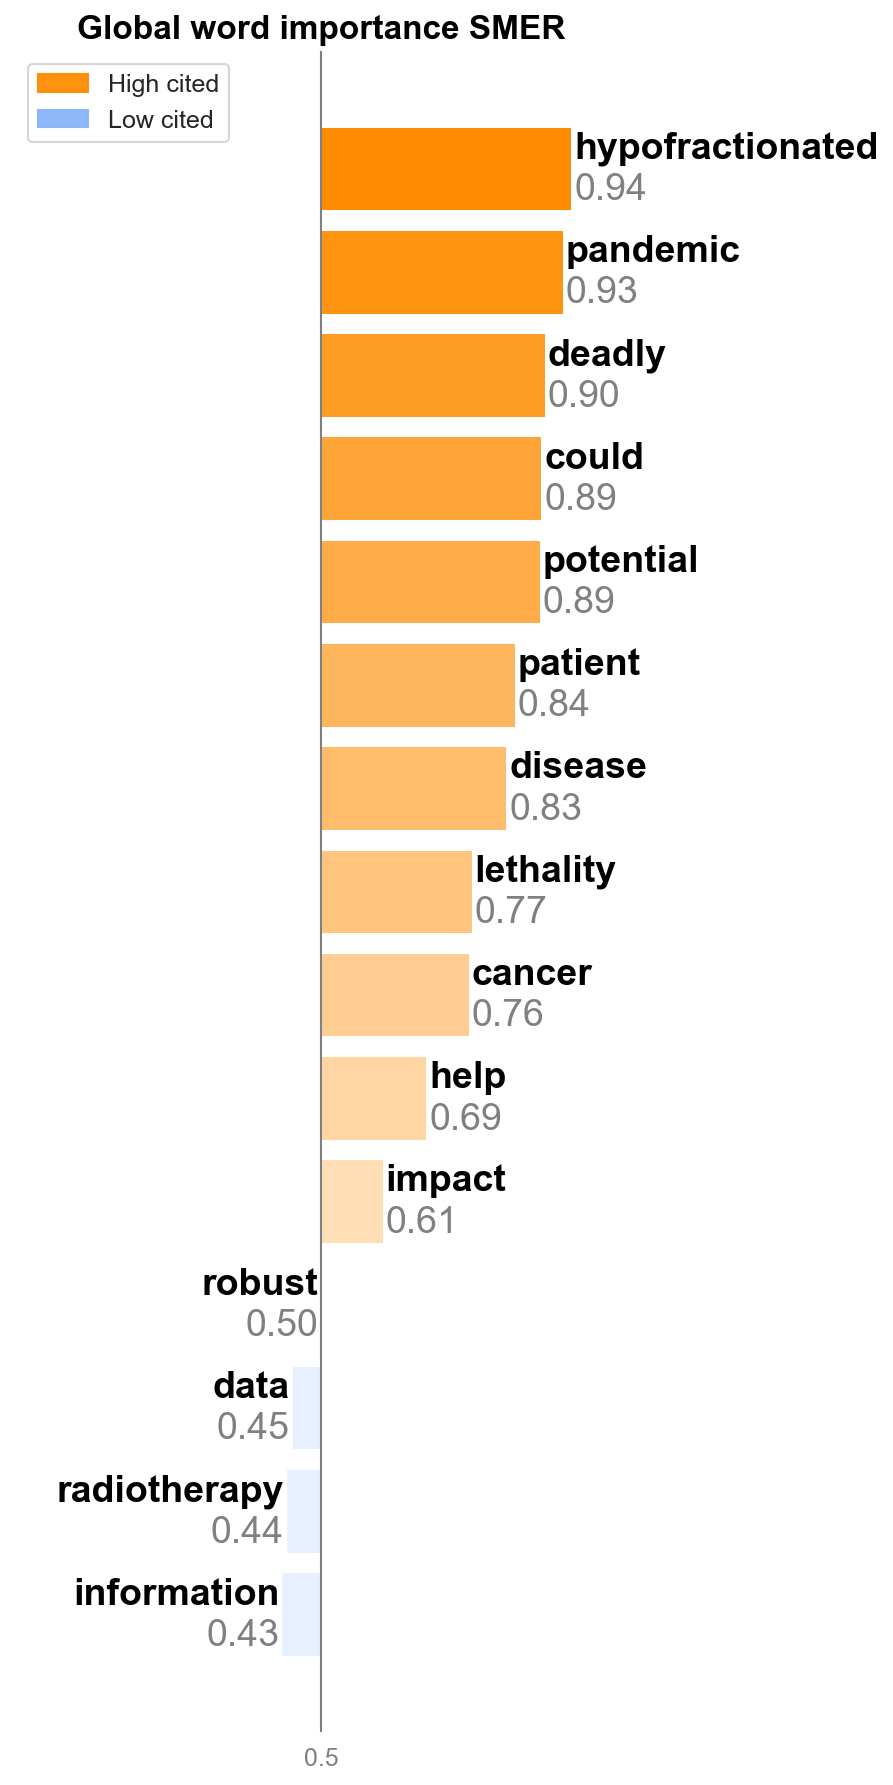

In [91]:
doi_of_interest = "10.1016/j.radonc.2020.05.032"
absolute=False

display_plots_with_abstract(doi_of_interest, lime_df_word_metrics_merged, absolute=absolute)